# Notebook 04 — Model Training & Evaluation

Train and compare **6 models** on each target using **5-fold cross-validation**, then hypertune the best performers.

| # | Model | Type |
|---|-------|------|
| 1 | Logistic / Linear Regression | Baseline |
| 2 | Decision Tree | Tree |
| 3 | Random Forest | Ensemble (bagging) |
| 4 | K-Nearest Neighbors | Instance-based |
| 5 | Gradient Boosting | Ensemble (boosting) |
| 6 | SVM / SVR | Margin-based |

Both pipelines use `StandardScaler`-transformed data saved from Notebook 03.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, joblib, time

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc, roc_auc_score,
    mean_squared_error, mean_absolute_error, r2_score
)

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor,
                               GradientBoostingClassifier, GradientBoostingRegressor)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 110
print("Libraries loaded.")

Libraries loaded.


## 1 · Load Prepared Data

In [2]:
# Classification data
X_train_clf = pd.read_csv('../data/processed/X_train_clf.csv')
X_test_clf  = pd.read_csv('../data/processed/X_test_clf.csv')
y_train_clf = pd.read_csv('../data/processed/y_train_clf.csv').squeeze()
y_test_clf  = pd.read_csv('../data/processed/y_test_clf.csv').squeeze()

# Regression data
X_train_reg = pd.read_csv('../data/processed/X_train_reg.csv')
X_test_reg  = pd.read_csv('../data/processed/X_test_reg.csv')
y_train_reg = pd.read_csv('../data/processed/y_train_reg.csv').squeeze()
y_test_reg  = pd.read_csv('../data/processed/y_test_reg.csv').squeeze()

print("Classification — Train:", X_train_clf.shape, " Test:", X_test_clf.shape)
print("Regression     — Train:", X_train_reg.shape, " Test:", X_test_reg.shape)
print(f"\nClassification target balance: {y_train_clf.mean():.2%} profitable")
print(f"Regression target mean: {y_train_reg.mean():.2f} (std {y_train_reg.std():.2f})")

Classification — Train: (4281, 40)  Test: (1071, 40)
Regression     — Train: (4281, 41)  Test: (1071, 41)

Classification target balance: 69.94% profitable
Regression target mean: 6.28 (std 0.90)


---
## 2 · Classification — Predict `is_profitable`

### 2.1 · Define Models & Cross-Validate

In [3]:
clf_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree':       DecisionTreeClassifier(random_state=42),
    'Random Forest':       RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'KNN':                 KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting':   GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM':                 SVC(kernel='rbf', probability=True, random_state=42),
}

cv_results_clf = {}
print(f"{'Model':<25} {'Accuracy':>10} {'F1':>10} {'ROC-AUC':>10}  Time")
print("=" * 70)

for name, model in clf_models.items():
    t0 = time.time()
    acc_scores = cross_val_score(model, X_train_clf, y_train_clf, cv=5, scoring='accuracy')
    f1_scores  = cross_val_score(model, X_train_clf, y_train_clf, cv=5, scoring='f1')
    auc_scores = cross_val_score(model, X_train_clf, y_train_clf, cv=5, scoring='roc_auc')
    elapsed = time.time() - t0

    cv_results_clf[name] = {
        'accuracy_mean': acc_scores.mean(), 'accuracy_std': acc_scores.std(),
        'f1_mean': f1_scores.mean(), 'f1_std': f1_scores.std(),
        'auc_mean': auc_scores.mean(), 'auc_std': auc_scores.std(),
    }
    print(f"{name:<25} {acc_scores.mean():.4f}±{acc_scores.std():.3f}"
          f" {f1_scores.mean():.4f}±{f1_scores.std():.3f}"
          f" {auc_scores.mean():.4f}±{auc_scores.std():.3f}"
          f"  {elapsed:.1f}s")

Model                       Accuracy         F1    ROC-AUC  Time
Logistic Regression       0.7755±0.009 0.8457±0.007 0.8259±0.015  0.2s
Decision Tree             0.7059±0.009 0.7887±0.007 0.6535±0.011  0.4s
Random Forest             0.7774±0.011 0.8489±0.008 0.8290±0.018  2.3s
KNN                       0.7087±0.013 0.7999±0.012 0.6980±0.010  2.0s
Gradient Boosting         0.7912±0.012 0.8570±0.008 0.8421±0.020  8.3s
SVM                       0.7489±0.007 0.8360±0.005 0.7877±0.021  17.3s


### 2.2 · Cross-Validation Scores Comparison

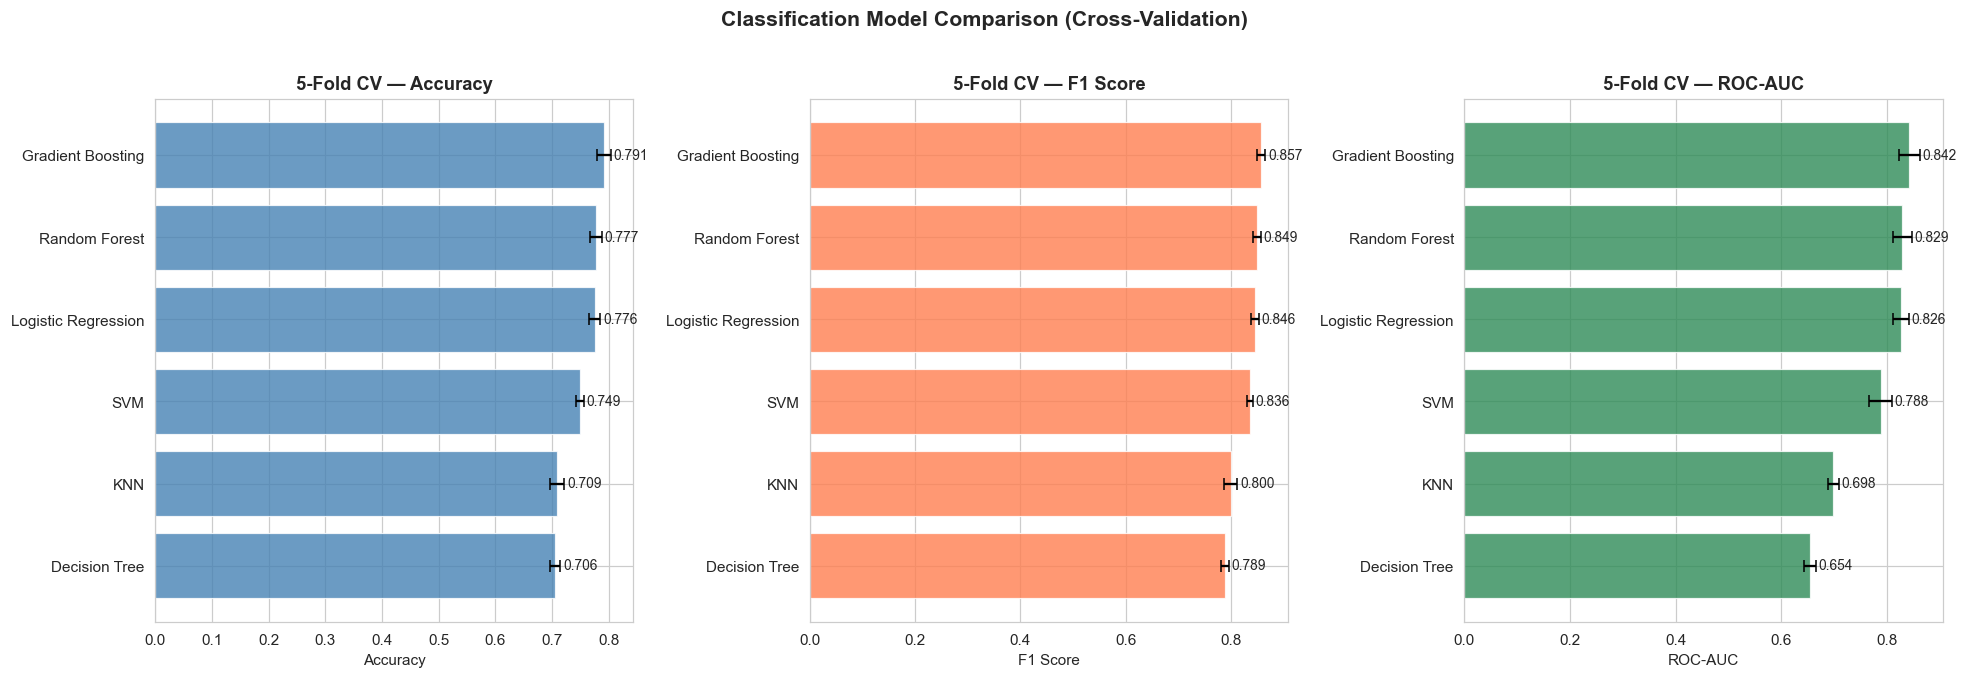

In [4]:
cv_df_clf = pd.DataFrame(cv_results_clf).T

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
metrics = [('accuracy_mean', 'accuracy_std', 'Accuracy', 'steelblue'),
           ('f1_mean', 'f1_std', 'F1 Score', 'coral'),
           ('auc_mean', 'auc_std', 'ROC-AUC', 'seagreen')]

for ax, (m, s, title, color) in zip(axes, metrics):
    vals = cv_df_clf[m].sort_values(ascending=True)
    errs = cv_df_clf.loc[vals.index, s]
    ax.barh(vals.index, vals.values, xerr=errs.values, color=color, alpha=0.8,
            capsize=4, edgecolor='white', linewidth=0.8)
    ax.set_xlabel(title)
    ax.set_title(f'5-Fold CV — {title}', fontweight='bold')
    for i, (v, e) in enumerate(zip(vals.values, errs.values)):
        ax.text(v + e + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

plt.suptitle('Classification Model Comparison (Cross-Validation)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 2.3 · Test Set Evaluation

In [5]:
test_results_clf = {}

for name, model in clf_models.items():
    model.fit(X_train_clf, y_train_clf)
    y_pred = model.predict(X_test_clf)
    y_prob = model.predict_proba(X_test_clf)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test_clf)

    test_results_clf[name] = {
        'accuracy':  accuracy_score(y_test_clf, y_pred),
        'precision': precision_score(y_test_clf, y_pred),
        'recall':    recall_score(y_test_clf, y_pred),
        'f1':        f1_score(y_test_clf, y_pred),
        'roc_auc':   roc_auc_score(y_test_clf, y_prob),
        'y_pred':    y_pred,
        'y_prob':    y_prob,
    }

test_df_clf = pd.DataFrame({k: {m: v for m, v in vals.items() if m not in ('y_pred', 'y_prob')}
                             for k, vals in test_results_clf.items()}).T
test_df_clf = test_df_clf.sort_values('f1', ascending=False)
print("Test Set Results (Classification)")
print("=" * 70)
print(test_df_clf.round(4).to_string())

Test Set Results (Classification)
                     accuracy  precision  recall      f1  roc_auc
Random Forest          0.7946     0.8237  0.8985  0.8595   0.8546
Gradient Boosting      0.7965     0.8323  0.8879  0.8592   0.8581
Logistic Regression    0.7684     0.8143  0.8665  0.8396   0.8378
SVM                    0.7460     0.7701  0.9079  0.8333   0.8154
KNN                    0.7208     0.7698  0.8571  0.8111   0.7075
Decision Tree          0.7031     0.8006  0.7664  0.7831   0.6611


### 2.4 · Confusion Matrices

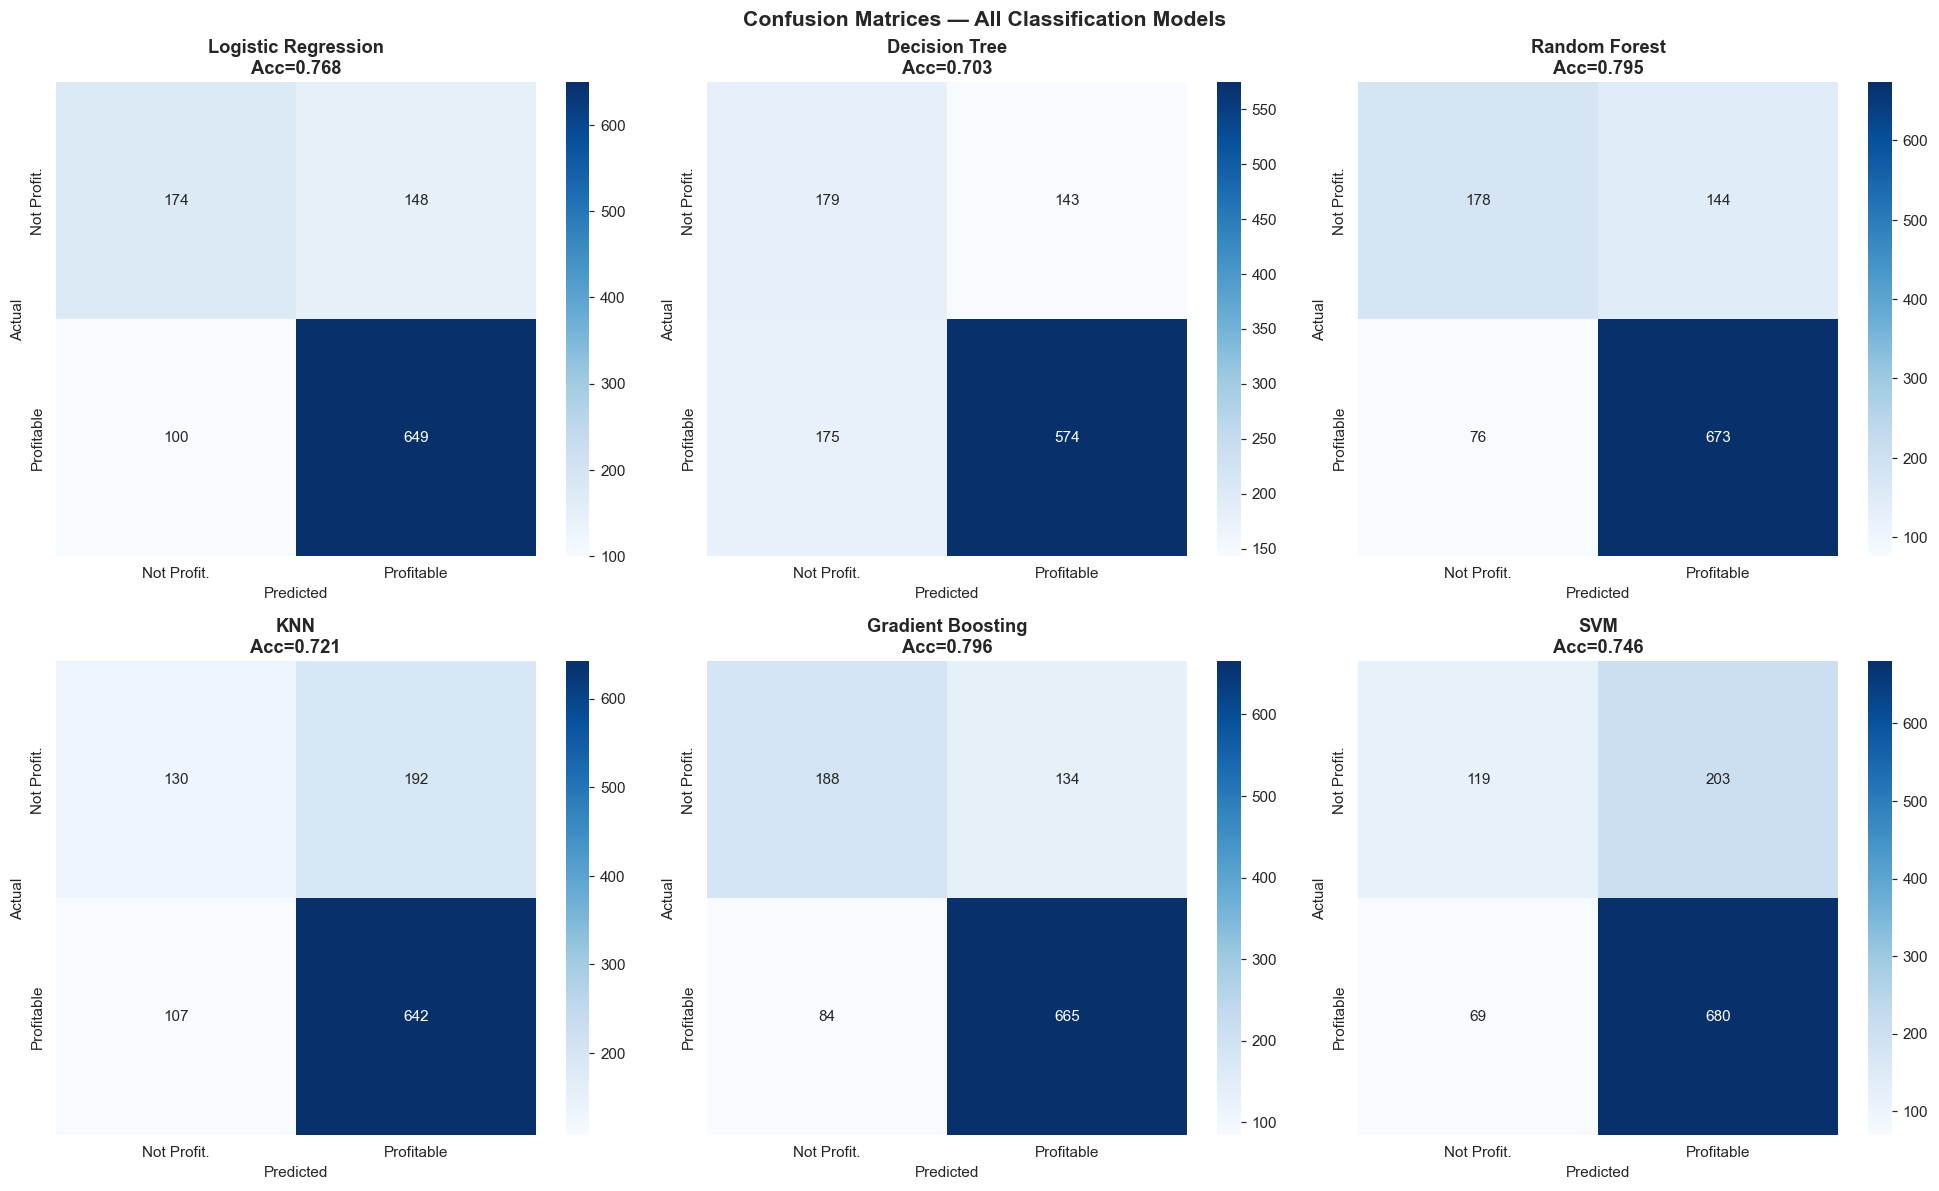

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(18, 11))
axes = axes.ravel()

for ax, name in zip(axes, clf_models.keys()):
    cm = confusion_matrix(y_test_clf, test_results_clf[name]['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Not Profit.', 'Profitable'],
                yticklabels=['Not Profit.', 'Profitable'])
    acc = test_results_clf[name]['accuracy']
    ax.set_title(f'{name}\nAcc={acc:.3f}', fontweight='bold')
    ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')

plt.suptitle('Confusion Matrices — All Classification Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 2.5 · ROC Curves

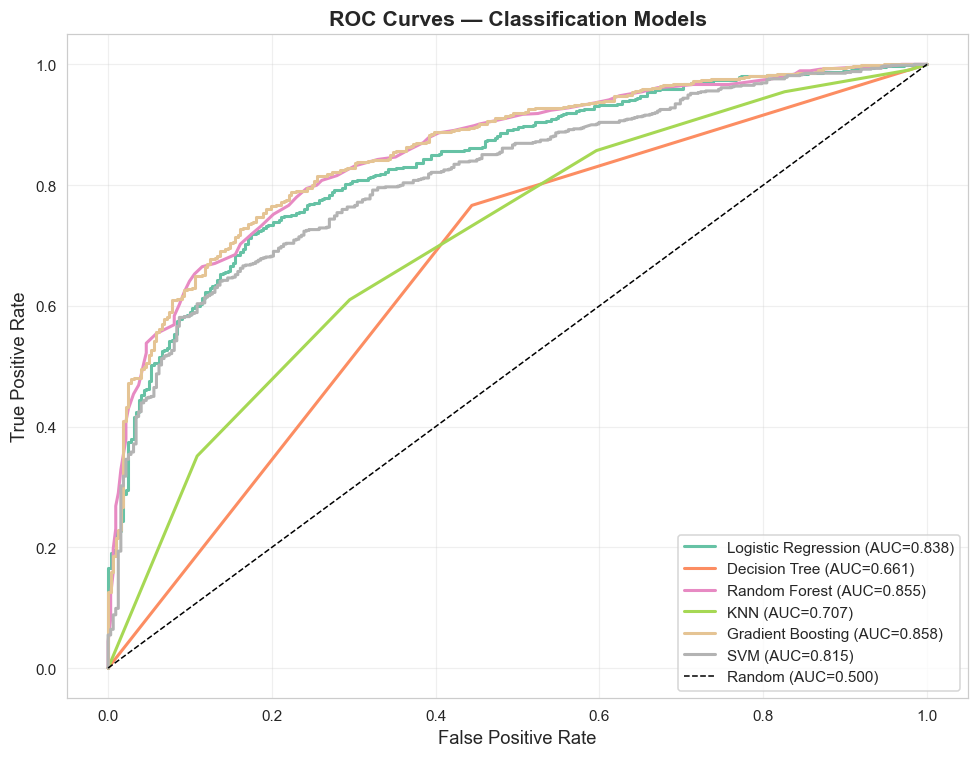

In [7]:
fig, ax = plt.subplots(figsize=(9, 7))
colors = plt.cm.Set2(np.linspace(0, 1, len(clf_models)))

for (name, res), color in zip(test_results_clf.items(), colors):
    fpr, tpr, _ = roc_curve(y_test_clf, res['y_prob'])
    roc_auc_val = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC={roc_auc_val:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC=0.500)')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves — Classification Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 2.6 · Feature Importance (Tree-Based Models)

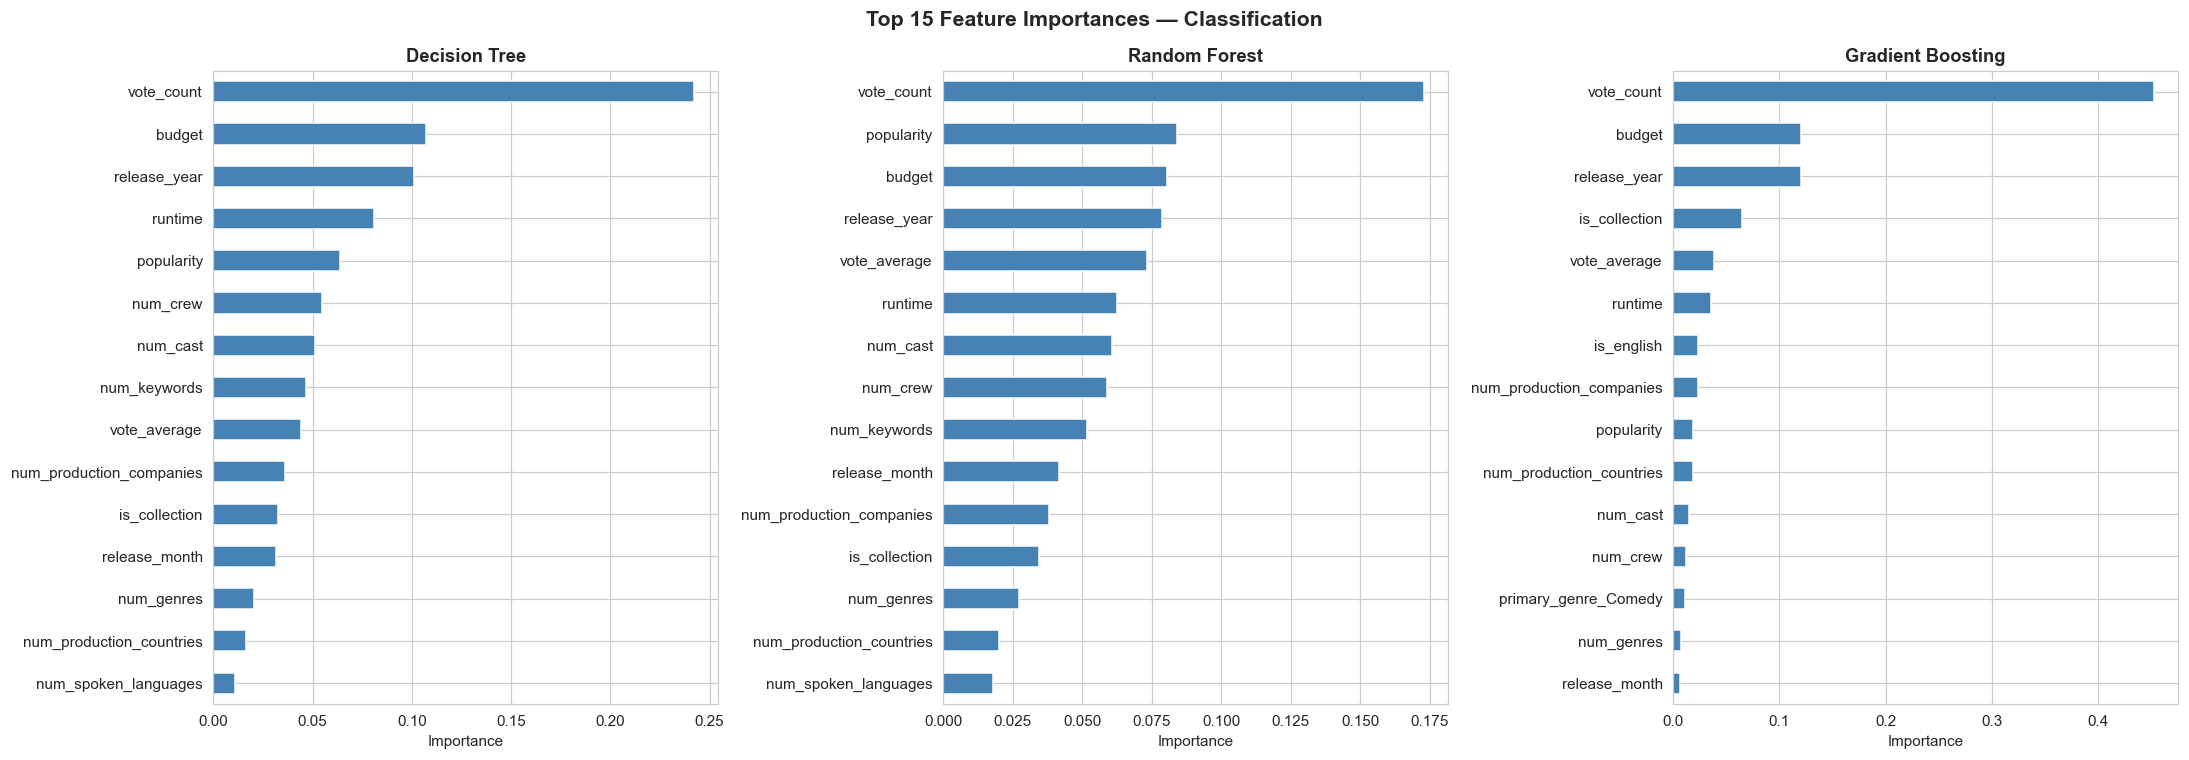

In [8]:
tree_models_clf = {
    'Decision Tree': clf_models['Decision Tree'],
    'Random Forest': clf_models['Random Forest'],
    'Gradient Boosting': clf_models['Gradient Boosting'],
}

fig, axes = plt.subplots(1, 3, figsize=(20, 7))
for ax, (name, model) in zip(axes, tree_models_clf.items()):
    importances = pd.Series(model.feature_importances_, index=X_train_clf.columns)
    top15 = importances.nlargest(15)
    top15.sort_values().plot.barh(ax=ax, color='steelblue', edgecolor='white')
    ax.set_title(f'{name}', fontweight='bold')
    ax.set_xlabel('Importance')

plt.suptitle('Top 15 Feature Importances — Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 2.7 · Hyperparameter Tuning

GridSearchCV on the **top 2 models** from cross-validation.

In [9]:
# Pick top 2 by CV F1
top2_clf_names = cv_df_clf['f1_mean'].nlargest(2).index.tolist()
print(f"Tuning: {top2_clf_names}")

param_grids_clf = {
    'Decision Tree': {
        'max_depth': [3, 5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 11, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'poly'],
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
    },
}

tuned_clf = {}
for name in top2_clf_names:
    print(f"\n{'='*60}")
    print(f"Tuning: {name}")
    print(f"{'='*60}")
    grid = GridSearchCV(
        clf_models[name].__class__(**{'random_state': 42} if 'random_state' in clf_models[name].get_params() else {}),
        param_grids_clf[name], cv=5, scoring='f1', n_jobs=-1, verbose=0
    )
    grid.fit(X_train_clf, y_train_clf)
    tuned_clf[name] = grid

    print(f"Best params : {grid.best_params_}")
    print(f"Best CV F1  : {grid.best_score_:.4f}")

    y_pred_tuned = grid.predict(X_test_clf)
    print(f"Test Accuracy: {accuracy_score(y_test_clf, y_pred_tuned):.4f}")
    print(f"Test F1      : {f1_score(y_test_clf, y_pred_tuned):.4f}")

Tuning: ['Gradient Boosting', 'Random Forest']

Tuning: Gradient Boosting
Best params : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best CV F1  : 0.8577
Test Accuracy: 0.7983
Test F1      : 0.8596

Tuning: Random Forest
Best params : {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best CV F1  : 0.8571
Test Accuracy: 0.7937
Test F1      : 0.8599


### 2.8 · Default vs Tuned Comparison

            Model Version  Accuracy     F1  ROC-AUC
Gradient Boosting Default    0.7965 0.8592   0.8581
Gradient Boosting   Tuned    0.7983 0.8596   0.8600
    Random Forest Default    0.7946 0.8595   0.8546
    Random Forest   Tuned    0.7937 0.8599   0.8546


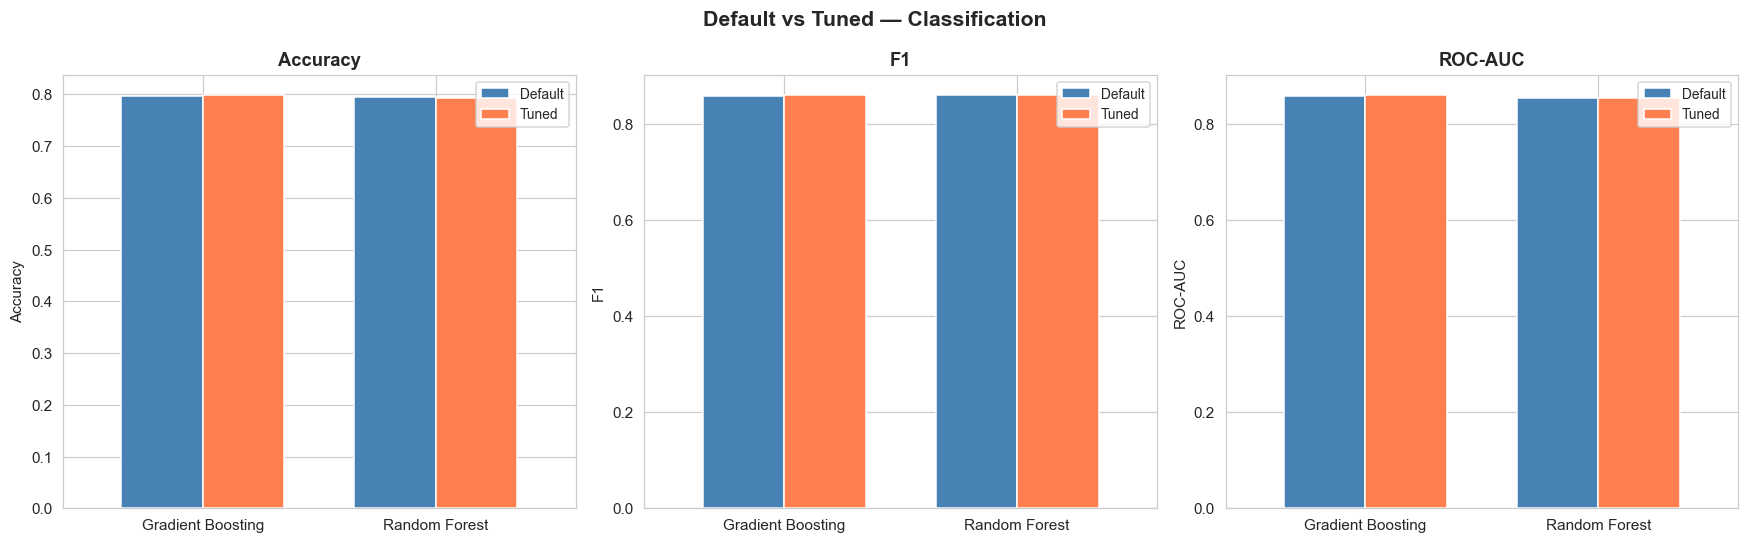

In [10]:
comparison_rows = []
for name in top2_clf_names:
    # Default
    y_pred_def = test_results_clf[name]['y_pred']
    # Tuned
    y_pred_tuned = tuned_clf[name].predict(X_test_clf)

    comparison_rows.append({
        'Model': name, 'Version': 'Default',
        'Accuracy': accuracy_score(y_test_clf, y_pred_def),
        'F1': f1_score(y_test_clf, y_pred_def),
        'ROC-AUC': test_results_clf[name]['roc_auc'],
    })
    y_prob_tuned = tuned_clf[name].predict_proba(X_test_clf)[:, 1] if hasattr(tuned_clf[name], 'predict_proba') else tuned_clf[name].decision_function(X_test_clf)
    comparison_rows.append({
        'Model': name, 'Version': 'Tuned',
        'Accuracy': accuracy_score(y_test_clf, y_pred_tuned),
        'F1': f1_score(y_test_clf, y_pred_tuned),
        'ROC-AUC': roc_auc_score(y_test_clf, y_prob_tuned),
    })

comp_df = pd.DataFrame(comparison_rows)
print(comp_df.round(4).to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for ax, metric in zip(axes, ['Accuracy', 'F1', 'ROC-AUC']):
    pivot = comp_df.pivot(index='Model', columns='Version', values=metric)
    pivot[['Default', 'Tuned']].plot.bar(ax=ax, color=['steelblue', 'coral'],
                                          edgecolor='white', width=0.7)
    ax.set_title(metric, fontweight='bold')
    ax.set_ylabel(metric); ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(fontsize=9)

plt.suptitle('Default vs Tuned — Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 2.9 · Select & Save Best Classifier

In [11]:
# Determine the overall best (tuned or default)
best_clf_name = comp_df.sort_values('F1', ascending=False).iloc[0]
print(f"Best classifier: {best_clf_name['Model']} ({best_clf_name['Version']})")
print(f"  Accuracy : {best_clf_name['Accuracy']:.4f}")
print(f"  F1       : {best_clf_name['F1']:.4f}")
print(f"  ROC-AUC  : {best_clf_name['ROC-AUC']:.4f}")

# Get the actual model object
best_clf_model_name = best_clf_name['Model']
if best_clf_name['Version'] == 'Tuned':
    best_clf_final = tuned_clf[best_clf_model_name].best_estimator_
else:
    best_clf_final = clf_models[best_clf_model_name]

# Save
os.makedirs('../models', exist_ok=True)
joblib.dump(best_clf_final, '../models/best_clf_model.pkl')
print(f"\nSaved to models/best_clf_model.pkl")

# Final classification report
y_pred_final_clf = best_clf_final.predict(X_test_clf)
print(f"\nFinal Classification Report:")
print(classification_report(y_test_clf, y_pred_final_clf,
                            target_names=['Not Profitable', 'Profitable']))

Best classifier: Random Forest (Tuned)
  Accuracy : 0.7937
  F1       : 0.8599
  ROC-AUC  : 0.8546

Saved to models/best_clf_model.pkl

Final Classification Report:
                precision    recall  f1-score   support

Not Profitable       0.71      0.53      0.61       322
    Profitable       0.82      0.91      0.86       749

      accuracy                           0.79      1071
     macro avg       0.76      0.72      0.73      1071
  weighted avg       0.79      0.79      0.78      1071



---
## 3 · Regression — Predict `vote_average`

### 3.1 · Define Models & Cross-Validate

In [12]:
reg_models = {
    'Linear Regression':  LinearRegression(),
    'Decision Tree':      DecisionTreeRegressor(random_state=42),
    'Random Forest':      RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'KNN':                KNeighborsRegressor(n_neighbors=5),
    'Gradient Boosting':  GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR':                SVR(kernel='rbf'),
}

cv_results_reg = {}
print(f"{'Model':<25} {'RMSE':>12} {'MAE':>12} {'R²':>12}  Time")
print("=" * 75)

for name, model in reg_models.items():
    t0 = time.time()
    neg_mse = cross_val_score(model, X_train_reg, y_train_reg, cv=5, scoring='neg_mean_squared_error')
    mae_sc  = cross_val_score(model, X_train_reg, y_train_reg, cv=5, scoring='neg_mean_absolute_error')
    r2_sc   = cross_val_score(model, X_train_reg, y_train_reg, cv=5, scoring='r2')
    elapsed = time.time() - t0

    rmse_vals = np.sqrt(-neg_mse)
    mae_vals  = -mae_sc

    cv_results_reg[name] = {
        'rmse_mean': rmse_vals.mean(), 'rmse_std': rmse_vals.std(),
        'mae_mean': mae_vals.mean(), 'mae_std': mae_vals.std(),
        'r2_mean': r2_sc.mean(), 'r2_std': r2_sc.std(),
    }
    print(f"{name:<25} {rmse_vals.mean():.4f}±{rmse_vals.std():.3f}"
          f" {mae_vals.mean():.4f}±{mae_vals.std():.3f}"
          f" {r2_sc.mean():.4f}±{r2_sc.std():.3f}"
          f"  {elapsed:.1f}s")

Model                             RMSE          MAE           R²  Time
Linear Regression         0.7197±0.033 0.5384±0.017 0.3589±0.033  0.1s
Decision Tree             0.9368±0.036 0.7053±0.025 -0.0877±0.069  0.5s
Random Forest             0.6605±0.026 0.4907±0.015 0.4596±0.031  3.4s
KNN                       0.8063±0.029 0.6195±0.013 0.1949±0.038  0.1s
Gradient Boosting         0.6522±0.027 0.4851±0.014 0.4729±0.033  8.6s
SVR                       0.6878±0.040 0.5043±0.025 0.4143±0.045  6.4s


### 3.2 · Cross-Validation Scores Comparison

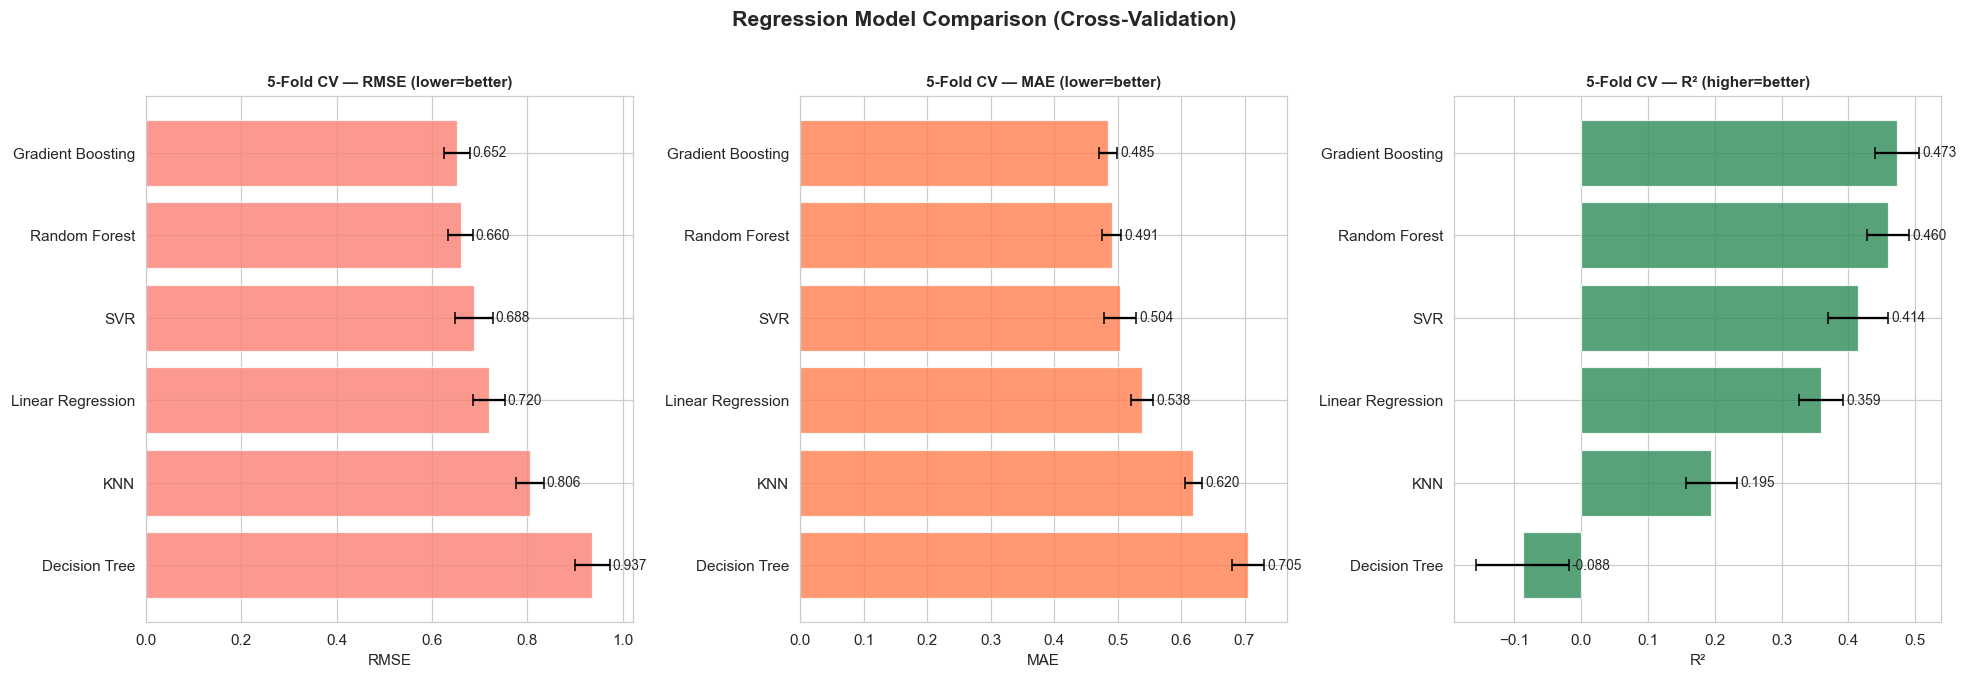

In [13]:
cv_df_reg = pd.DataFrame(cv_results_reg).T

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
metrics_reg = [('rmse_mean', 'rmse_std', 'RMSE (lower=better)', 'salmon'),
               ('mae_mean', 'mae_std', 'MAE (lower=better)', 'coral'),
               ('r2_mean', 'r2_std', 'R² (higher=better)', 'seagreen')]

for ax, (m, s, title, color) in zip(axes, metrics_reg):
    ascending = True if 'better' in title and 'lower' in title else False
    vals = cv_df_reg[m].sort_values(ascending=not ascending)
    errs = cv_df_reg.loc[vals.index, s]
    ax.barh(vals.index, vals.values, xerr=errs.values, color=color, alpha=0.8,
            capsize=4, edgecolor='white', linewidth=0.8)
    ax.set_xlabel(title.split('(')[0].strip())
    ax.set_title(f'5-Fold CV — {title}', fontweight='bold', fontsize=10)
    for i, (v, e) in enumerate(zip(vals.values, errs.values)):
        ax.text(v + e + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

plt.suptitle('Regression Model Comparison (Cross-Validation)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.3 · Test Set Evaluation

In [14]:
test_results_reg = {}

for name, model in reg_models.items():
    model.fit(X_train_reg, y_train_reg)
    y_pred = model.predict(X_test_reg)

    test_results_reg[name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred)),
        'MAE':  mean_absolute_error(y_test_reg, y_pred),
        'R²':   r2_score(y_test_reg, y_pred),
        'y_pred': y_pred,
    }

test_df_reg = pd.DataFrame({k: {m: v for m, v in vals.items() if m != 'y_pred'}
                             for k, vals in test_results_reg.items()}).T
test_df_reg = test_df_reg.sort_values('R²', ascending=False)
print("Test Set Results (Regression)")
print("=" * 50)
print(test_df_reg.round(4).to_string())

Test Set Results (Regression)
                     RMSE     MAE      R²
Gradient Boosting  0.6213  0.4717  0.5012
Random Forest      0.6338  0.4780  0.4810
SVR                0.6398  0.4756  0.4711
Linear Regression  0.6830  0.5244  0.3971
KNN                0.7747  0.5911  0.2243
Decision Tree      0.9647  0.7269 -0.2025


### 3.4 · Actual vs Predicted Plots

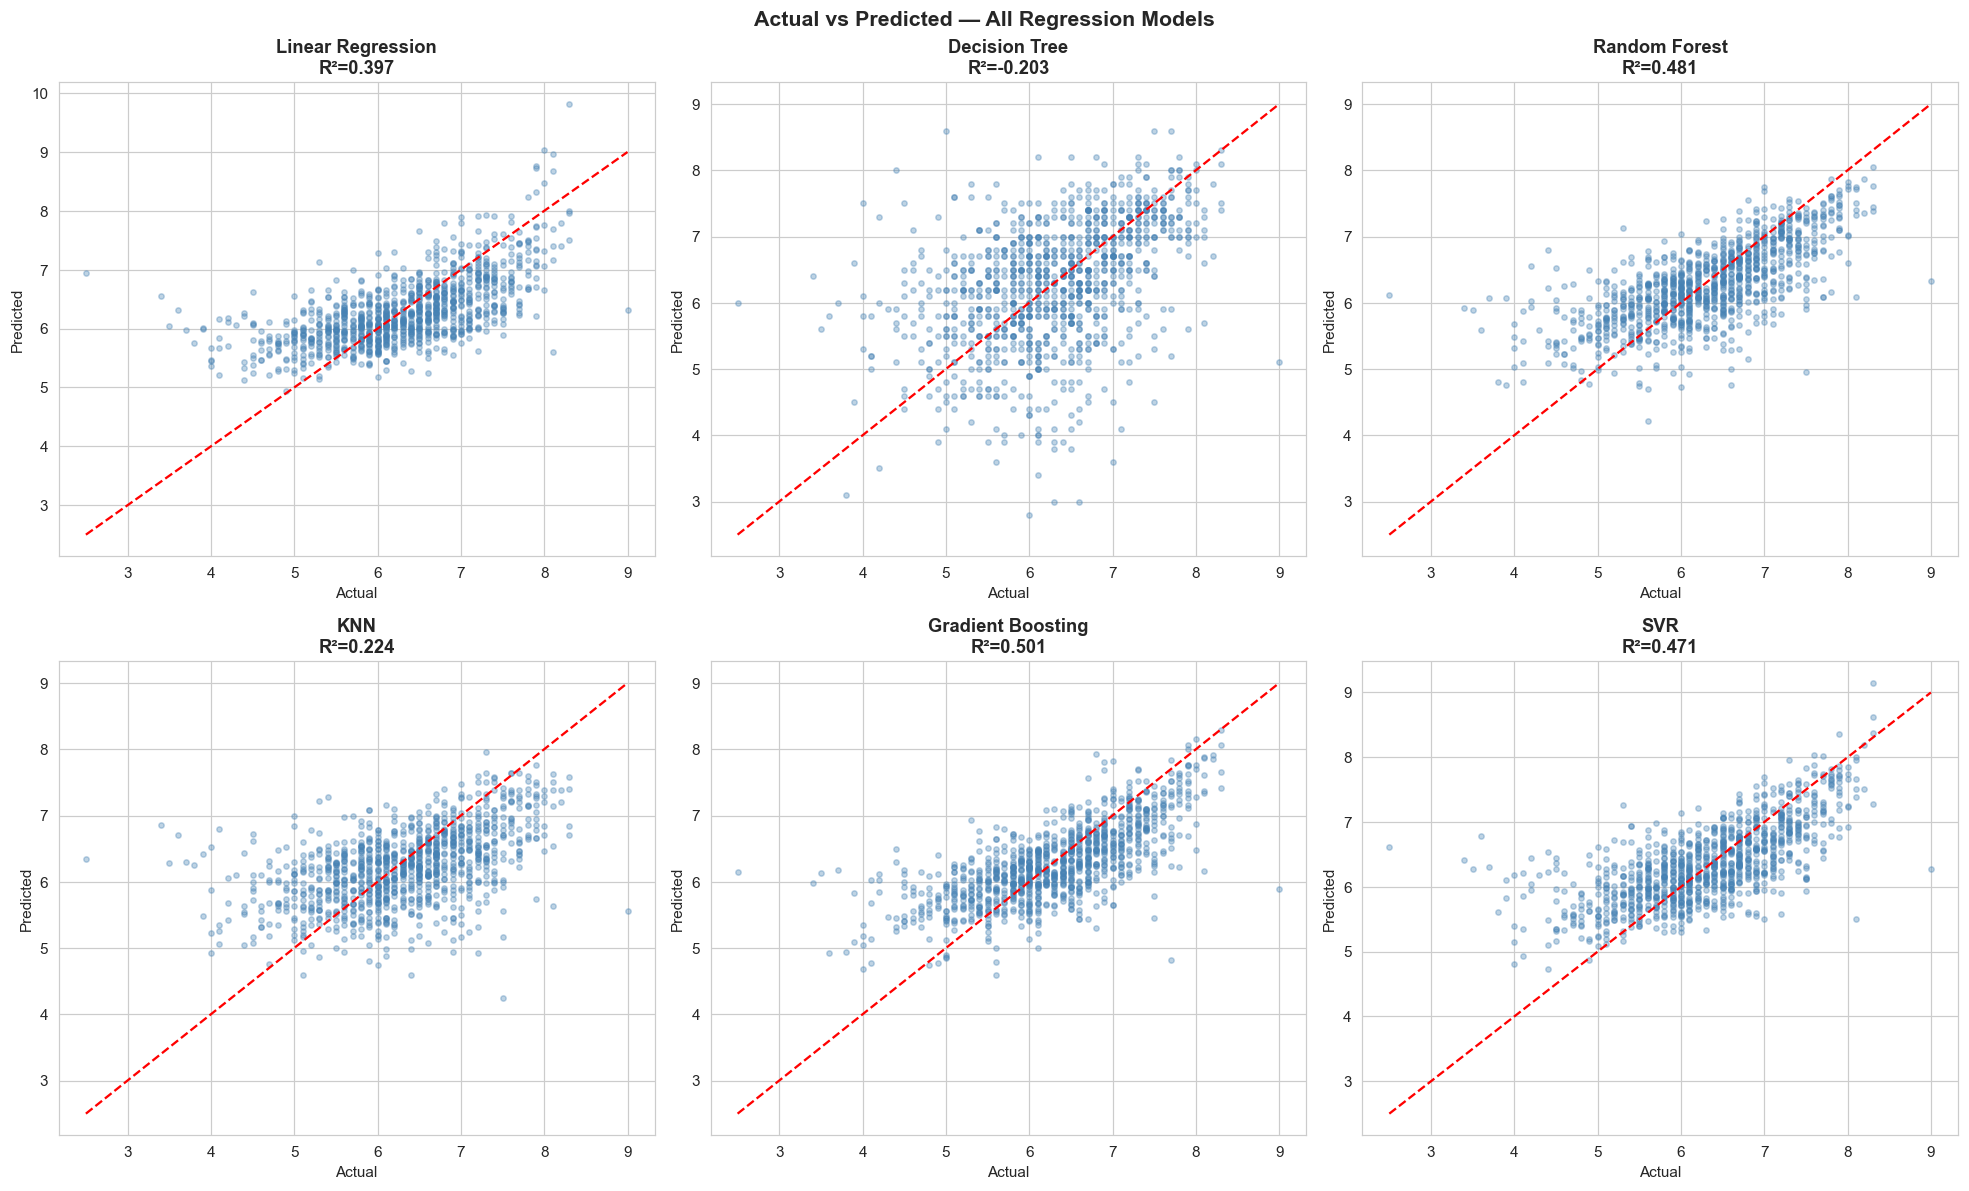

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(18, 11))
axes = axes.ravel()

for ax, name in zip(axes, reg_models.keys()):
    y_pred = test_results_reg[name]['y_pred']
    r2_val = test_results_reg[name]['R²']
    ax.scatter(y_test_reg, y_pred, alpha=0.35, s=12, color='steelblue')
    mn, mx = y_test_reg.min(), y_test_reg.max()
    ax.plot([mn, mx], [mn, mx], 'r--', lw=1.5)
    ax.set_xlabel('Actual'); ax.set_ylabel('Predicted')
    ax.set_title(f'{name}\nR²={r2_val:.3f}', fontweight='bold')

plt.suptitle('Actual vs Predicted — All Regression Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.5 · Residual Distributions

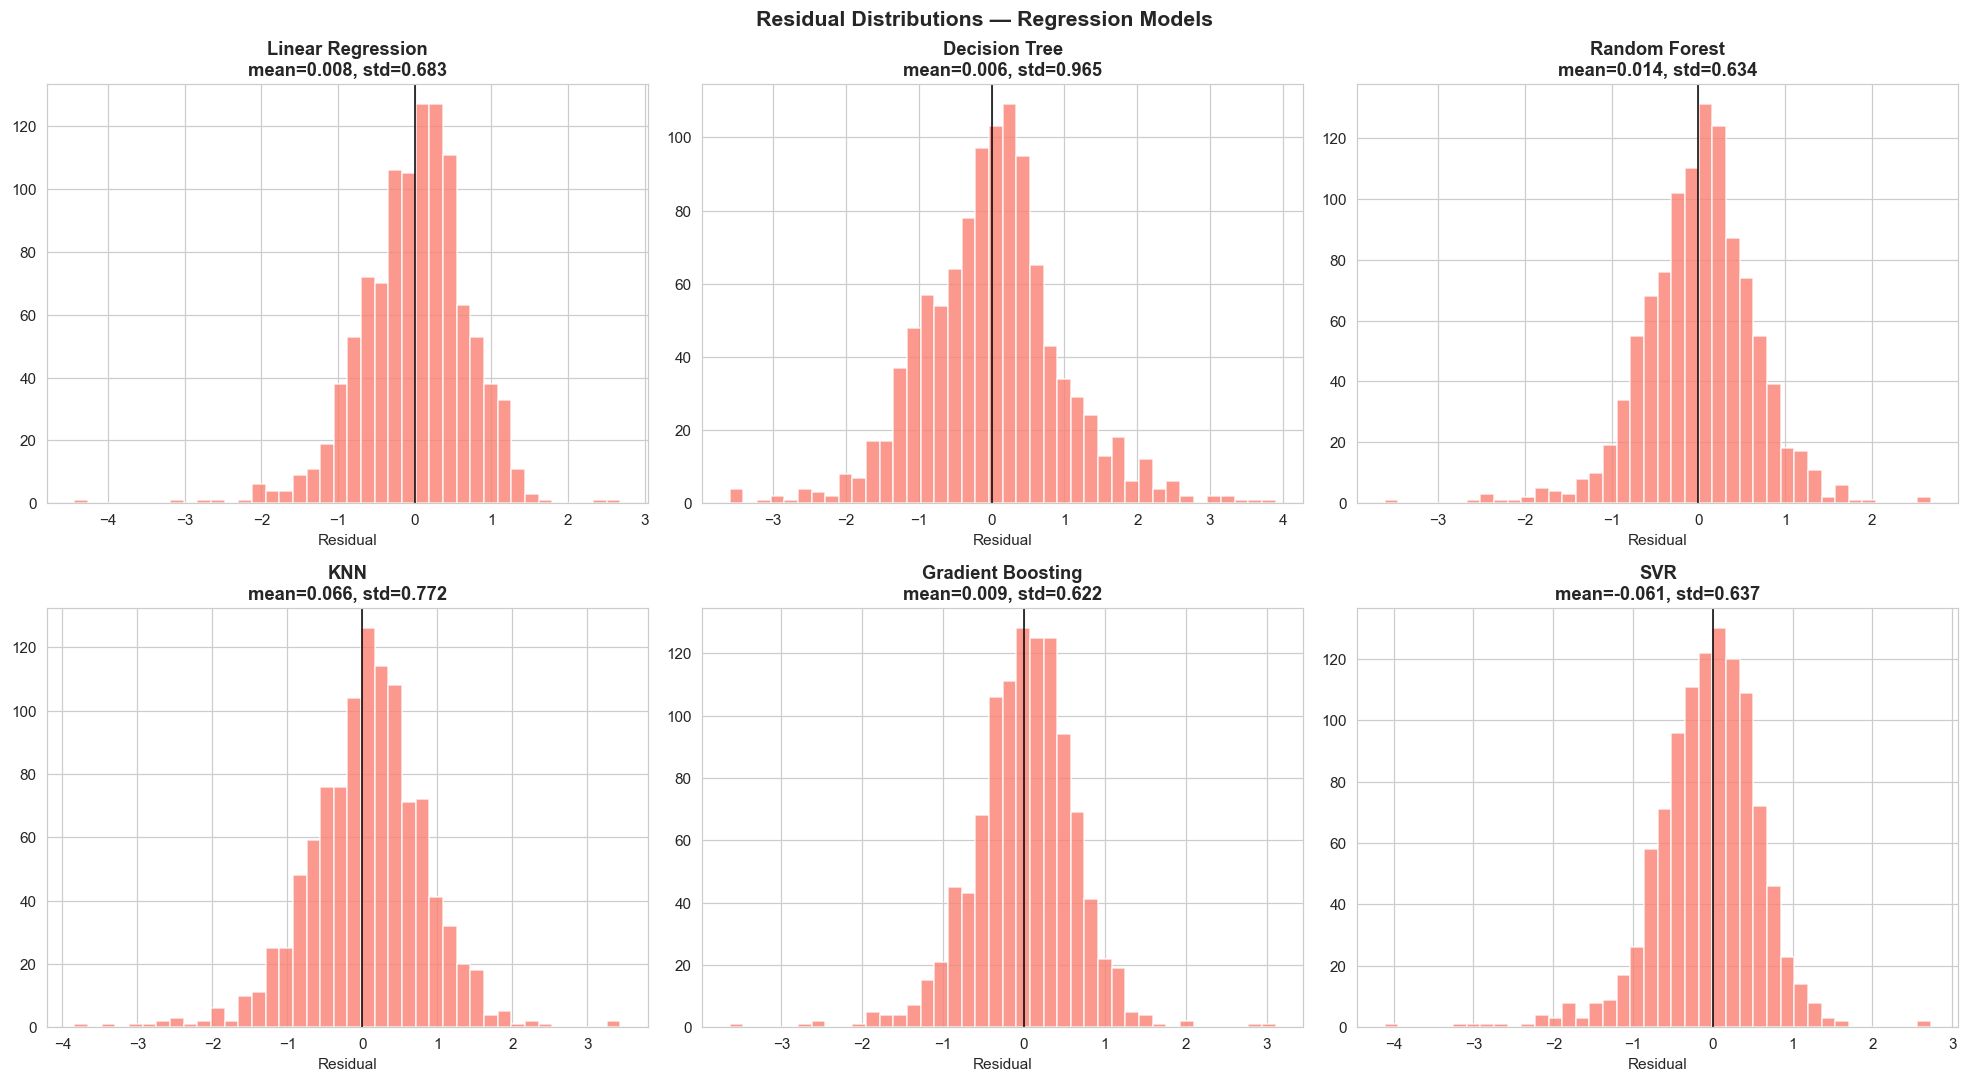

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for ax, name in zip(axes, reg_models.keys()):
    residuals = y_test_reg - test_results_reg[name]['y_pred']
    ax.hist(residuals, bins=40, color='salmon', edgecolor='white', alpha=0.8)
    ax.axvline(0, color='black', lw=1)
    ax.set_xlabel('Residual')
    ax.set_title(f'{name}\nmean={residuals.mean():.3f}, std={residuals.std():.3f}', fontweight='bold')

plt.suptitle('Residual Distributions — Regression Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.6 · Feature Importance (Tree-Based Models)

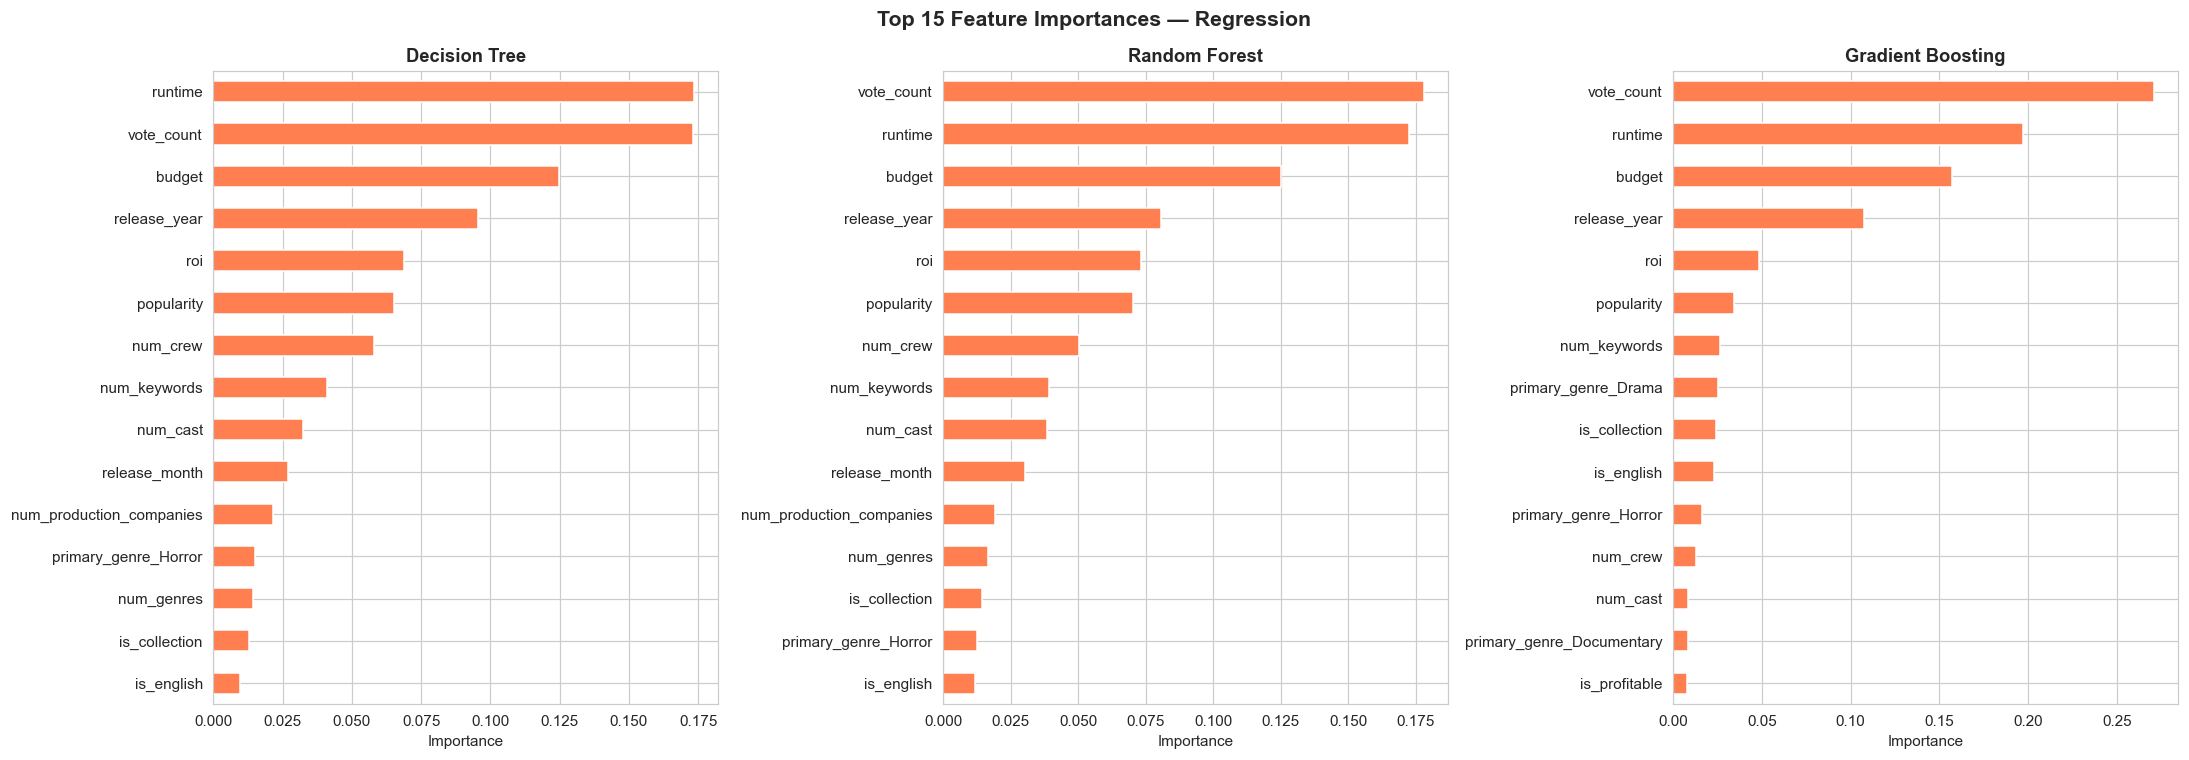

In [17]:
tree_models_reg = {
    'Decision Tree': reg_models['Decision Tree'],
    'Random Forest': reg_models['Random Forest'],
    'Gradient Boosting': reg_models['Gradient Boosting'],
}

fig, axes = plt.subplots(1, 3, figsize=(20, 7))
for ax, (name, model) in zip(axes, tree_models_reg.items()):
    importances = pd.Series(model.feature_importances_, index=X_train_reg.columns)
    top15 = importances.nlargest(15)
    top15.sort_values().plot.barh(ax=ax, color='coral', edgecolor='white')
    ax.set_title(f'{name}', fontweight='bold')
    ax.set_xlabel('Importance')

plt.suptitle('Top 15 Feature Importances — Regression', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.7 · Hyperparameter Tuning

GridSearchCV on the **top 2 models** by CV R².

In [18]:
top2_reg_names = cv_df_reg['r2_mean'].nlargest(2).index.tolist()
print(f"Tuning: {top2_reg_names}")

param_grids_reg = {
    'Decision Tree': {
        'max_depth': [3, 5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 11, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'poly'],
    },
    'Linear Regression': {},
}

tuned_reg = {}
for name in top2_reg_names:
    print(f"\n{'='*60}")
    print(f"Tuning: {name}")
    print(f"{'='*60}")
    if not param_grids_reg.get(name):
        print("No hyperparameters to tune (Linear Regression).")
        continue
    grid = GridSearchCV(
        reg_models[name].__class__(**{'random_state': 42} if 'random_state' in reg_models[name].get_params() else {}),
        param_grids_reg[name], cv=5, scoring='r2', n_jobs=-1, verbose=0
    )
    grid.fit(X_train_reg, y_train_reg)
    tuned_reg[name] = grid

    print(f"Best params : {grid.best_params_}")
    print(f"Best CV R²  : {grid.best_score_:.4f}")

    y_pred_tuned = grid.predict(X_test_reg)
    print(f"Test RMSE   : {np.sqrt(mean_squared_error(y_test_reg, y_pred_tuned)):.4f}")
    print(f"Test R²     : {r2_score(y_test_reg, y_pred_tuned):.4f}")

Tuning: ['Gradient Boosting', 'Random Forest']

Tuning: Gradient Boosting
Best params : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best CV R²  : 0.4907
Test RMSE   : 0.6131
Test R²     : 0.5142

Tuning: Random Forest
Best params : {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best CV R²  : 0.4639
Test RMSE   : 0.6278
Test R²     : 0.4906


### 3.8 · Default vs Tuned Comparison

            Model Version   RMSE    MAE     R²
Gradient Boosting Default 0.6213 0.4717 0.5012
Gradient Boosting   Tuned 0.6131 0.4604 0.5142
    Random Forest Default 0.6338 0.4780 0.4810
    Random Forest   Tuned 0.6278 0.4729 0.4906


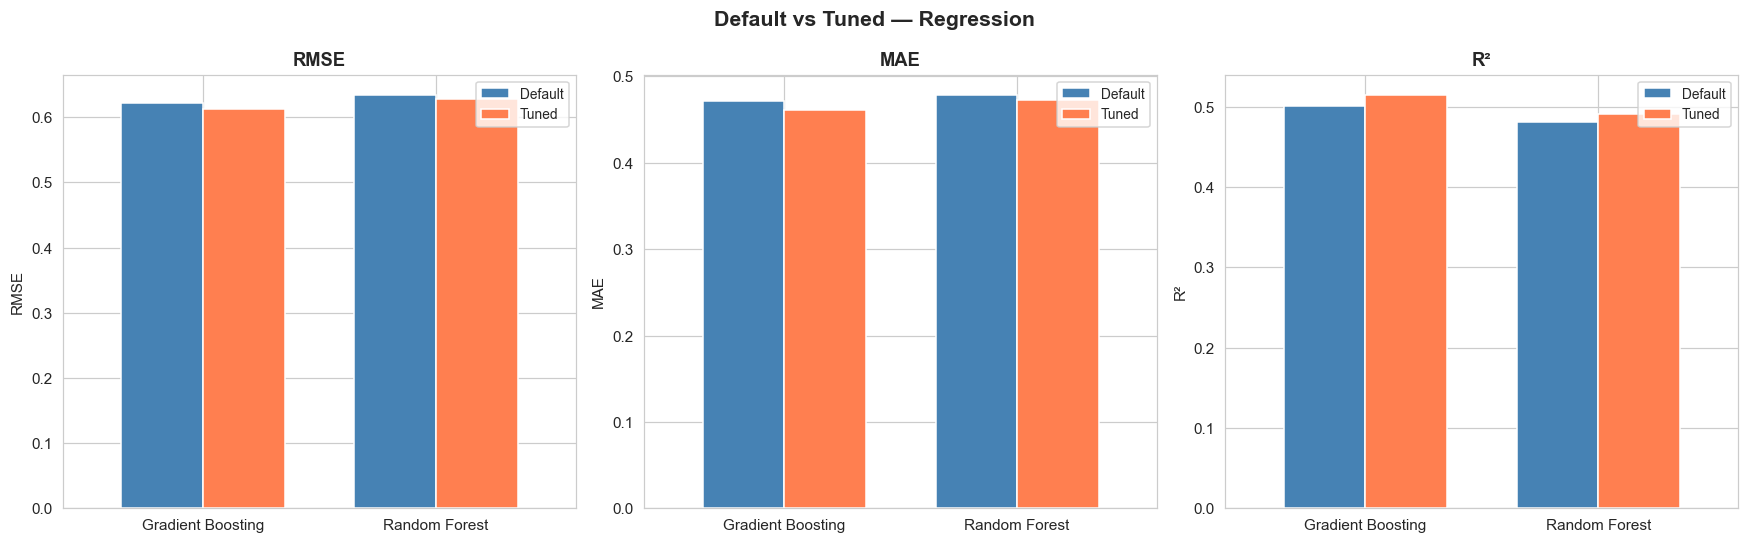

In [19]:
comparison_rows_reg = []
for name in top2_reg_names:
    y_pred_def = test_results_reg[name]['y_pred']
    comparison_rows_reg.append({
        'Model': name, 'Version': 'Default',
        'RMSE': test_results_reg[name]['RMSE'],
        'MAE': test_results_reg[name]['MAE'],
        'R²': test_results_reg[name]['R²'],
    })
    if name in tuned_reg:
        y_pred_tuned = tuned_reg[name].predict(X_test_reg)
        comparison_rows_reg.append({
            'Model': name, 'Version': 'Tuned',
            'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_tuned)),
            'MAE': mean_absolute_error(y_test_reg, y_pred_tuned),
            'R²': r2_score(y_test_reg, y_pred_tuned),
        })

comp_df_reg = pd.DataFrame(comparison_rows_reg)
print(comp_df_reg.round(4).to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for ax, metric in zip(axes, ['RMSE', 'MAE', 'R²']):
    pivot = comp_df_reg.pivot(index='Model', columns='Version', values=metric)
    cols = [c for c in ['Default', 'Tuned'] if c in pivot.columns]
    pivot[cols].plot.bar(ax=ax, color=['steelblue', 'coral'], edgecolor='white', width=0.7)
    ax.set_title(metric, fontweight='bold')
    ax.set_ylabel(metric); ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(fontsize=9)

plt.suptitle('Default vs Tuned — Regression', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.9 · Select & Save Best Regressor

Best regressor: Gradient Boosting (Tuned)
  RMSE : 0.6131
  MAE  : 0.4604
  R²   : 0.5142

Saved to models/best_reg_model.pkl


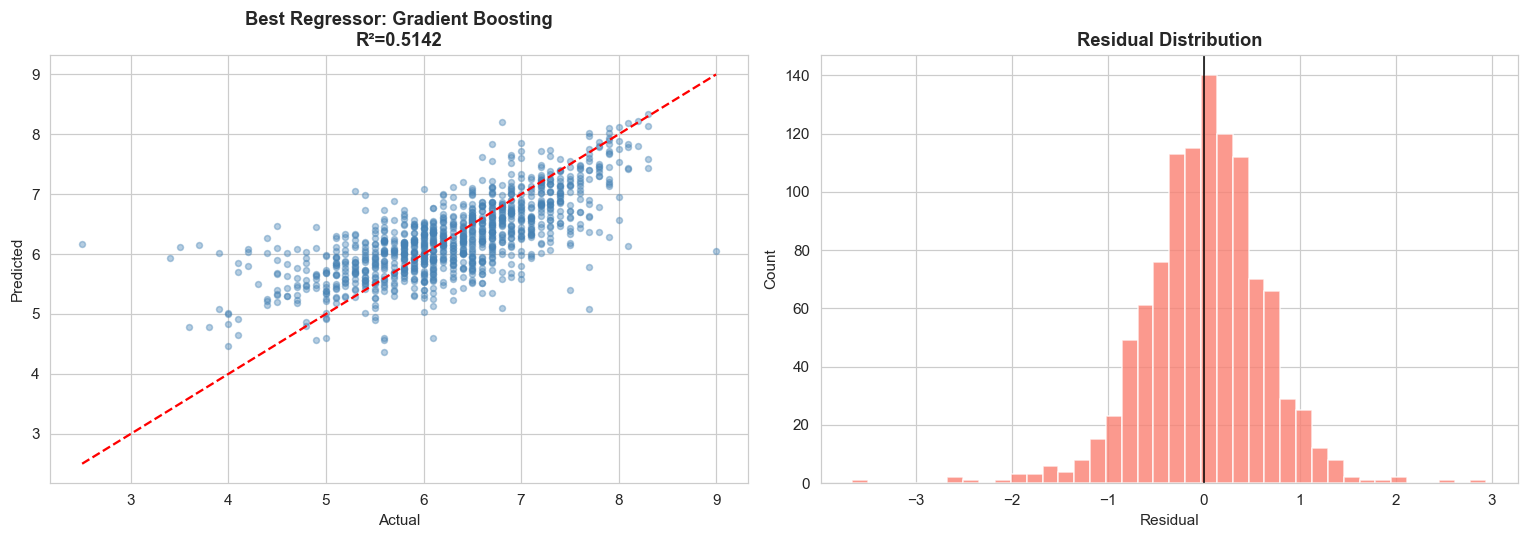

In [20]:
best_reg_row = comp_df_reg.sort_values('R²', ascending=False).iloc[0]
print(f"Best regressor: {best_reg_row['Model']} ({best_reg_row['Version']})")
print(f"  RMSE : {best_reg_row['RMSE']:.4f}")
print(f"  MAE  : {best_reg_row['MAE']:.4f}")
print(f"  R²   : {best_reg_row['R²']:.4f}")

best_reg_model_name = best_reg_row['Model']
if best_reg_row['Version'] == 'Tuned' and best_reg_model_name in tuned_reg:
    best_reg_final = tuned_reg[best_reg_model_name].best_estimator_
else:
    best_reg_final = reg_models[best_reg_model_name]

joblib.dump(best_reg_final, '../models/best_reg_model.pkl')
print(f"\nSaved to models/best_reg_model.pkl")

# Final scatter
y_pred_final_reg = best_reg_final.predict(X_test_reg)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test_reg, y_pred_final_reg, alpha=0.4, s=15, color='steelblue')
mn, mx = y_test_reg.min(), y_test_reg.max()
axes[0].plot([mn, mx], [mn, mx], 'r--', lw=1.5)
axes[0].set_xlabel('Actual'); axes[0].set_ylabel('Predicted')
axes[0].set_title(f'Best Regressor: {best_reg_row["Model"]}\nR²={best_reg_row["R²"]:.4f}', fontweight='bold')

residuals = y_test_reg - y_pred_final_reg
axes[1].hist(residuals, bins=40, color='salmon', edgecolor='white', alpha=0.8)
axes[1].axvline(0, color='black', lw=1)
axes[1].set_xlabel('Residual'); axes[1].set_ylabel('Count')
axes[1].set_title('Residual Distribution', fontweight='bold')
plt.tight_layout(); plt.show()

---
## 4 · Summary

### Saved Artifacts
| File | Description |
|------|-------------|
| `models/best_clf_model.pkl` | Best classification model (is_profitable) |
| `models/best_reg_model.pkl` | Best regression model (vote_average) |
| `models/scaler_clf.pkl` | StandardScaler for classification features |
| `models/scaler_reg.pkl` | StandardScaler for regression features |

### Next Steps
1. Fill `src/` modules with reusable pipeline code
2. Build a **FastAPI** prediction API that loads these artifacts
3. Add input validation and error handling
4. (Optional) Dockerize the API